# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# read dataset

In [2]:
file_path = '40561_2022_192_MOESM1_ESM.xlsx'
df = pd.read_excel(file_path)

# analyse data

In [3]:
print("\nnumber of samples : " , df.count().max())
print(df.columns)


number of samples :  1854
Index(['stdID', 'mid-term', 'final', 'faculty', 'department'], dtype='object')


In [4]:
df.head()

,stdID,mid-term,final,faculty,department
0,std1,60,68,İKTİSADİ VE İDARİ BİLİMLER FAKÜLTESİ,Siyaset Bilimi ve Kamu Yönetimi
1,std2,34,67,BEDEN EĞİTİMİ VE SPOR YÜKSEKOKULU,Antrenörlük Eğitimi
2,std3,25,75,EĞİTİM FAKÜLTESİ,Bilgisayar ve Öğretim Teknolojileri Öğretmenliği
3,std4,50,66,EĞİTİM FAKÜLTESİ,Sosyal Bilgiler Öğretmenliği
4,std5,50,66,EĞİTİM FAKÜLTESİ,Okul Öncesi Öğretmenliği


In [5]:
df=df.drop(['stdID'],axis=1)
df=df.drop(['faculty'],axis=1)
df=df.drop(['department'],axis=1)

In [6]:
df.head()

,mid-term,final
0,60,68
1,34,67
2,25,75
3,50,66
4,50,66


# preprocessing

### convert to classes

In [7]:
# create criteria columns 
df['criteria']=1
# craeate a class for each row build in mid-term 
for i in range(df['criteria'].count()):
    if df.iloc[i,1]<32.5:
        df.iloc[i,2]=1
    elif (df.iloc[i,1] >=32.5) & (df.iloc[i,1]<55):
        df.iloc[i,2]=2
    elif (df.iloc[i,1] >=55) & (df.iloc[i,1]<77.5):
        df.iloc[i,2]=3
    elif (df.iloc[i,1] >=77.5):
        df.iloc[i,2]=4

In [8]:
df.head()

,mid-term,final,criteria
0,60,68,3
1,34,67,3
2,25,75,3
3,50,66,3
4,50,66,3


### Data imbalance check

In [9]:
print("The number of samples in the class 'grade<32.5' : " , df['criteria'][df['criteria'] == 1].count())
print("The number of samples in the class 'grade>=32.5 & grade<55' : " , df['criteria'][df['criteria'] == 2].count())
print("The number of samples in the class 'grade>=55 & grade<77.5' : " , df['criteria'][df['criteria'] == 3].count())
print("The number of samples in the class 'grade>=77.5' : " , df['criteria'][df['criteria'] == 4].count())

The number of samples in the class 'grade<32.5' :  38
The number of samples in the class 'grade>=32.5 & grade<55' :  154
The number of samples in the class 'grade>=55 & grade<77.5' :  1016
The number of samples in the class 'grade>=77.5' :  646


In [10]:
import plotly.express as px
labels=["criteria"]

dfs = df['criteria'].value_counts().to_dict()
values = [dfs[1], dfs[2], dfs[3], dfs[4]]
labels = ['grade<32.5', 'grade>=32.5 & grade<55', 'grade>=55 & grade<77.5', 'grade>=77.5']
colors = ["skyblue", "black", "green", "orange"]

fig = px.pie(values=values, names=labels, width=700, height=400, color_discrete_sequence=colors, title="Marks distribute")

fig.show()

### Checking for outliers

In [11]:
numerical_columns = list(df.loc[:,['mid-term']])
# categorical_columns = list(df.loc[:,['faculty', 'department']])

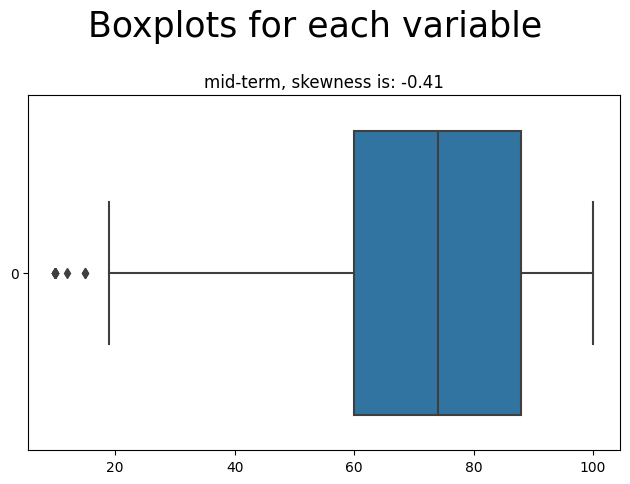

In [12]:
# checking boxplots
fig, axs = plt.subplots(1, 1, sharey=True)
fig.suptitle('Boxplots for each variable', y=1, size=25)

for i, data in enumerate(numerical_columns):
    sns.boxplot(data=df[data], orient='h', ax=axs)
    axs.set_title(data + ', skewness is: ' + str(round(df[data].skew(axis=0, skipna=True), 2)))

plt.tight_layout()

In [13]:
from collections import Counter
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
         # selecting observations containing more than x outliers
        outlier_list = Counter(outlier_list)        
        multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
        
        # Calculate the number of records below and above lower and above bound value respectively
        out1 = df[df[column] < Q1 - outlier_step]
        out2 = df[df[column] > Q3 + outlier_step]
        
        print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
        return multiple_outliers

In [14]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numerical_columns)

# dropping outliers
df = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 10


### imputation missing

In [15]:
df.isna().sum()

mid-term    0
final       0
criteria    0
dtype: int64

### Data Split

In [16]:
from sklearn.model_selection import train_test_split
df=df.drop(['final'],axis=1)

x=df.drop(['criteria'],axis=1)
y=df['criteria']

x_train ,x_test ,y_train ,y_test = train_test_split(x,y, test_size=0.3,shuffle=True, random_state=42)
x_train, x_test = x_train.reset_index(drop=True), x_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

### encoding

In [17]:
# from sklearn import preprocessing 

# label_encoder = preprocessing.LabelEncoder() 

# x_train['faculty'] = label_encoder.fit_transform(x_train['faculty']) 
# x_train['department'] = label_encoder.fit_transform(x_train['department']) 
# x_train.head()


In [18]:
# x_test['faculty'] = label_encoder.fit_transform(x_test['faculty']) 
# x_test['department'] = label_encoder.fit_transform(x_test['faculty']) 
# x_test.head()

### scaling

In [19]:
# x_train.describe().loc[['min', 'max']]

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# X_fields= ['mid-term','faculty','department']
# scaler = MinMaxScaler(feature_range=(-1, 1))

# # x_train_data_scaler
# x_train[X_fields] =scaler.fit_transform(x_train[X_fields])

# # x_test_data_scaler
# x_test[X_fields] =scaler.transform(x_test[X_fields])

In [21]:
# x_train.describe().loc[['min', 'max']]

# building and training and Validation models

### import

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix ,recall_score, precision_score, f1_score, accuracy_score, classification_report
from yellowbrick.classifier import ROCAUC

##############################################################################################

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

##############################################################################################

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

##############################################################################################

### confusion_matrix_plot

In [23]:
def confusion_matrix_plot(cm):
    classes = ['class 1', 'class 2' , 'class 3' , 'class 4']
    with np.errstate(divide='ignore', invalid='ignore'):
        cm = cm/np.sum(cm,axis=0)
    tick_marks = np.arange(4)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Dark2)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                        ha="center", va="center", color="w")
    plt.title('Normalized confusion matrix for model')
    fig.colorbar(im)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes);

### sensitivity & specificity

In [24]:
def sensitivity_specificity(cm):
    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = cm[:, i].sum() - true_positive
        false_negative = cm[i, :].sum() - true_positive
        true_negative = cm.sum() - (true_positive + false_positive + false_negative)

        sensitivity.append(true_positive / (true_positive + false_negative))
        specificity.append(true_negative / (true_negative + false_positive))

    print("Sensitivity for each class:", sensitivity)
    print("Specificity for each class:", specificity)
    for i in range(len(sensitivity)):
        print("Sensitivity for each class: ",i," is", sensitivity[i])
        print("Specificity for each class:",i," is", specificity[i])

### AUC (ROC plot)

In [25]:
def plot_ROC_curve(model, x_train, y_train, x_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: '1', 
                                        2: '2', 
                                        3: '3',
                                        4: '4'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    
    return visualizer

### plot tabel score

In [26]:
def table_score(ypred):
    Recall = recall_score(y_test, ypred, average='macro' , zero_division=1)
    Precision = precision_score(y_test, ypred, average='macro' , zero_division=1)
    f1 = f1_score(y_test, ypred, average='macro' , zero_division=1)
    accuracy = accuracy_score(y_test, ypred)
    ndf = [(Recall, Precision, f1, accuracy)]

    score = pd.DataFrame(data=ndf, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    return score

### KNN

In [27]:
knn1 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn1.fit(x_train , y_train)
print("Test score: {:.2f}".format(knn1.score(x_test , y_test)))

Test score: 0.63


In [28]:
param_grid_knn = {
    'n_neighbors': [1, 10 , 100], 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean' , 'cosine' , 'manhattan' , 'minkowski']
}
clf_knn = GridSearchCV(estimator= KNeighborsClassifier(), param_grid= param_grid_knn , cv=kfold, scoring='accuracy', verbose=3)
clf_knn.fit(x_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.585 total time=   0.0s
[CV 2/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.615 total time=   0.0s
[CV 3/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.577 total time=   0.0s
[CV 4/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.615 total time=   0.0s
[CV 5/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.500 total time=   0.0s
[CV 6/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.615 total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.592 total time=   0.0s
[CV 8/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.612 total time=   0.0s
[CV 9/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.589 total time=   0.0s
[CV 10/10] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0

[CV 4/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.615 total time=   0.0s
[CV 5/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.500 total time=   0.0s
[CV 6/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.615 total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.592 total time=   0.0s
[CV 8/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.612 total time=   0.0s
[CV 9/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.589 total time=   0.0s
[CV 10/10] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.488 total time=   0.0s
[CV 1/10] END metric=euclidean, n_neighbors=10, weights=uniform;, score=0.723 total time=   0.0s
[CV 2/10] END metric=euclidean, n_neighbors=10, weights=uniform;, score=0.708 total time=   0.0s
[CV 3/10] END metric=euclidean, n_neighbors=10, weights=uniform;, score=0.685 total time=   0.0s
[CV 4/10] END metric=euclidea

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'cosine', 'manhattan',
                                    'minkowski'],
                         'n_neighbors': [1, 10, 100],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [29]:
print("Best of Hyper Parameter :" , clf_knn.best_params_, "\nScore : " , clf_knn.best_score_)

Best of Hyper Parameter : {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'} 
Score :  0.6939355992844365


In [30]:
knn2 = clf_knn.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(knn2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(knn2.score(x_train, y_train)))

Test score for test_data: 0.65
Test score for train_data: 0.70


In [31]:
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores_clf1 = cross_val_score(knn2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf1)
print("Mean for k_fold cross validation for KNN model", np.mean(scores_clf1))

[0.72307692 0.70769231 0.68461538 0.68461538 0.66923077 0.70769231
 0.64615385 0.69767442 0.72868217 0.68992248]
Mean for k_fold cross validation for KNN model 0.6939355992844365


In [32]:
ypred1 = knn2.predict(x_test)
cm_knn = confusion_matrix(y_test, ypred1)
print("confusion_matrix(ytest, ypred): \n", cm_knn)

confusion_matrix(ytest, ypred): 
 [[  5   0   6   0]
 [  5   1  52   6]
 [  4   0 238  37]
 [  6   0  77 120]]


In [33]:
sensitivity_specificity(cm_knn)

Sensitivity for each class: [0.45454545454545453, 0.015625, 0.8530465949820788, 0.5911330049261084]
Specificity for each class: [0.9725274725274725, 1.0, 0.5143884892086331, 0.8785310734463276]
Sensitivity for each class:  0  is 0.45454545454545453
Specificity for each class: 0  is 0.9725274725274725
Sensitivity for each class:  1  is 0.015625
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.8530465949820788
Specificity for each class: 2  is 0.5143884892086331
Sensitivity for each class:  3  is 0.5911330049261084
Specificity for each class: 3  is 0.8785310734463276


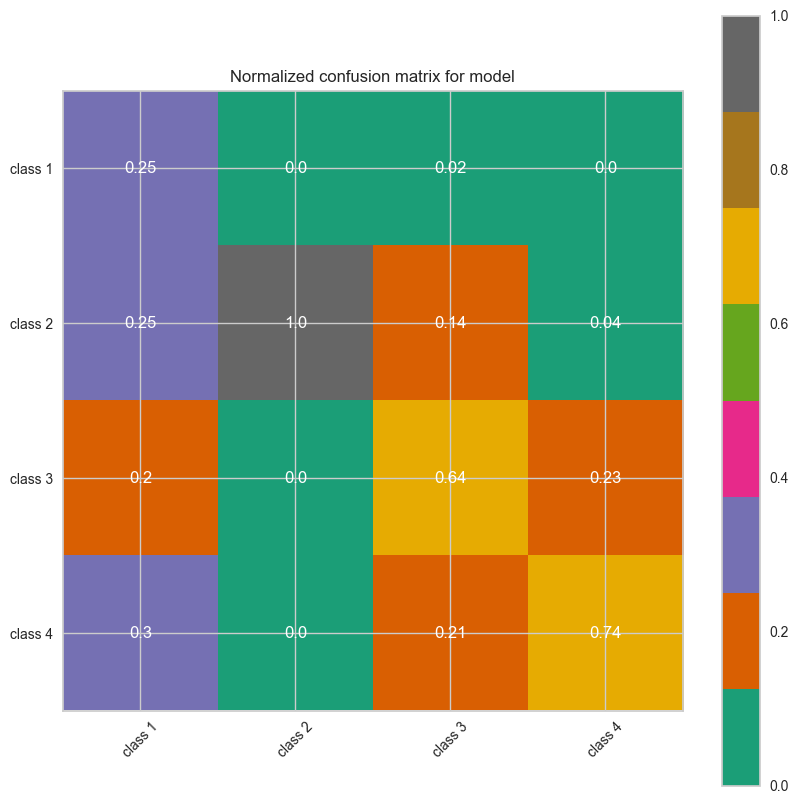

In [34]:
confusion_matrix_plot(cm_knn)

In [35]:
print("Classification Report:\n", classification_report(y_test, ypred1 , zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.45      0.32        11
           2       1.00      0.02      0.03        64
           3       0.64      0.85      0.73       279
           4       0.74      0.59      0.66       203

    accuracy                           0.65       557
   macro avg       0.66      0.48      0.43       557
weighted avg       0.71      0.65      0.61       557



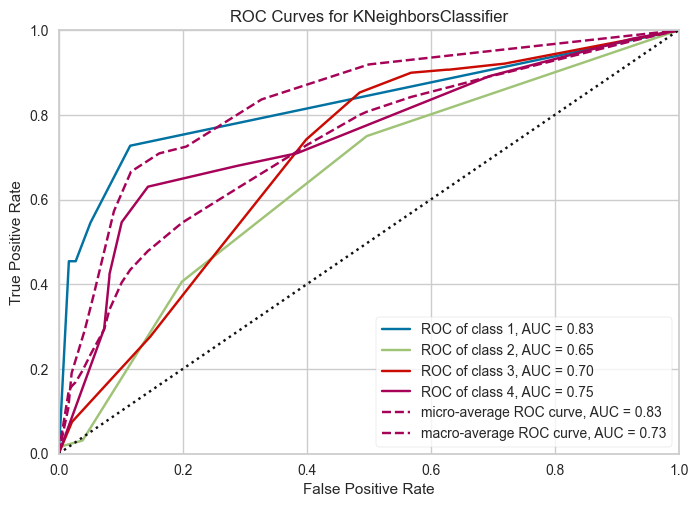

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=10))

In [36]:
plot_ROC_curve(knn2, x_train, y_train, x_test, y_test)

In [37]:
knn_score = table_score(ypred1)
knn_score.insert(0, 'Model', 'KNN')
knn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,KNN,0.478588,0.656067,0.434787,0.653501


### Logistic Regression

In [38]:
lr = LogisticRegression(multi_class="ovr")
lr.fit(x_train, y_train)
print("Test score: {:.2f}".format(lr.score(x_test , y_test)))

Test score: 0.63


In [39]:
param_grid_lr = { 
    'multi_class': ['auto' , 'ovr'] ,
    'solver': ['lbfgs' , 'liblinear'], 
    'C': [1, 2 , 4]
}
clf_lr = GridSearchCV(estimator= LogisticRegression() , param_grid= param_grid_lr , cv=kfold, scoring='accuracy', verbose=3)
clf_lr.fit(x_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.715 total time=   0.0s
[CV 2/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.685 total time=   0.0s
[CV 3/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.638 total time=   0.0s
[CV 4/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.685 total time=   0.0s
[CV 5/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.669 total time=   0.0s
[CV 6/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.700 total time=   0.0s
[CV 7/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.677 total time=   0.0s
[CV 8/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.682 total time=   0.0s
[CV 9/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.674 total time=   0.0s
[CV 10/10] END C=1, multi_class=auto, solver=lbfgs;, score=0.659 total time=   0.0s
[CV 1/10] END C=1, multi_class=auto, solver=liblinear;, score=0.715 total time=   0.0s
[CV 2/10] END C=1, 

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 4], 'multi_class': ['auto', 'ovr'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy', verbose=3)

In [40]:
print("Best of Hyper Parameter :" , clf_lr.best_params_, "\nScore : " , clf_lr.best_score_)

Best of Hyper Parameter : {'C': 1, 'multi_class': 'auto', 'solver': 'lbfgs'} 
Score :  0.6784734645199763


In [41]:
lr2 = clf_lr.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(lr2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(lr2.score(x_train, y_train)))

Test score for test_data: 0.63
Test score for train_data: 0.68


In [42]:
scores_clf2 = cross_val_score(lr2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf2)
print("Mean for k_fold cross validation for Logistic Regression model", np.mean(scores_clf2))

[0.71538462 0.68461538 0.63846154 0.68461538 0.66923077 0.7
 0.67692308 0.68217054 0.6744186  0.65891473]
Mean for k_fold cross validation for Logistic Regression model 0.6784734645199763


In [43]:
ypred2 = lr2.predict(x_test)
cm_lr = confusion_matrix(y_test, ypred2)
print("confusion_matrix(ytest, ypred): \n", cm_lr)

confusion_matrix(ytest, ypred): 
 [[  1   0  10   0]
 [  1   0  47  16]
 [  0   0 243  36]
 [  2   0  95 106]]


In [44]:
sensitivity_specificity(cm_lr)

Sensitivity for each class: [0.09090909090909091, 0.0, 0.8709677419354839, 0.5221674876847291]
Specificity for each class: [0.9945054945054945, 1.0, 0.45323741007194246, 0.8531073446327684]
Sensitivity for each class:  0  is 0.09090909090909091
Specificity for each class: 0  is 0.9945054945054945
Sensitivity for each class:  1  is 0.0
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.8709677419354839
Specificity for each class: 2  is 0.45323741007194246
Sensitivity for each class:  3  is 0.5221674876847291
Specificity for each class: 3  is 0.8531073446327684


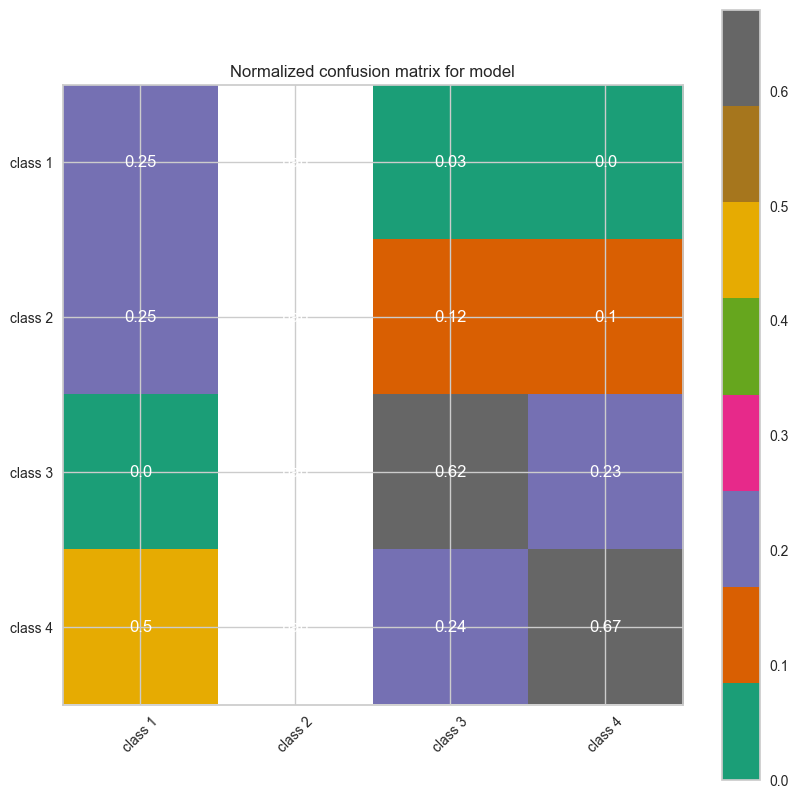

In [45]:
confusion_matrix_plot(cm_lr)

In [46]:
print("Classification Report:\n", classification_report(y_test, ypred2 , zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.09      0.13        11
           2       1.00      0.00      0.00        64
           3       0.62      0.87      0.72       279
           4       0.67      0.52      0.59       203

    accuracy                           0.63       557
   macro avg       0.63      0.37      0.36       557
weighted avg       0.67      0.63      0.58       557



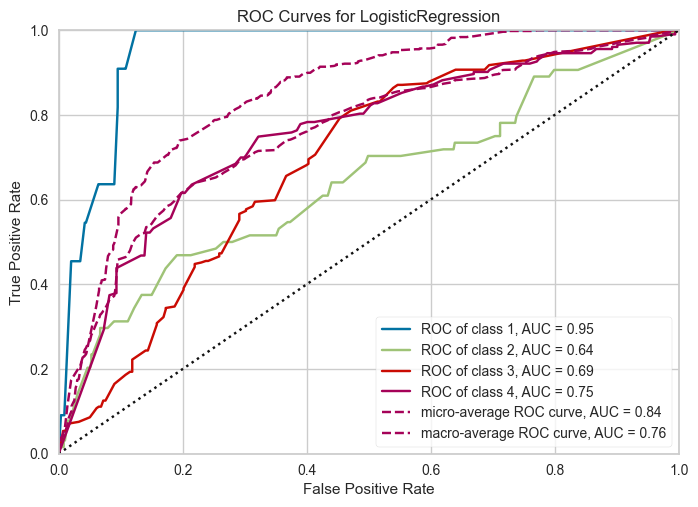

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=LogisticRegression(C=1))

In [47]:
plot_ROC_curve(lr2, x_train, y_train, x_test, y_test)

In [48]:
lr_score = table_score(ypred2)
lr_score.insert(0, 'Model', 'LR')
lr_score

,Model,Recall,Precision,F1 Score,Accuracy
0,LR,0.371011,0.634019,0.360415,0.628366


### SVM

In [49]:
svm = SVC(decision_function_shape='ovo')
svm.fit(x_train , y_train)
print("Test score: {:.2f}".format(svm.score(x_test , y_test)))

Test score: 0.61


In [50]:
param_grid_svm = { 
    'decision_function_shape': ['ovo' , 'ovr'],
    'kernel': ['rbf' , 'poly'], 
    'C': [1, 2 , 4 , 6]
}
clf_svm = GridSearchCV(estimator= SVC() , param_grid= param_grid_svm , cv=kfold, scoring='accuracy', verbose=3)
clf_svm.fit(x_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.715 total time=   0.0s
[CV 2/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.662 total time=   0.0s
[CV 3/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.677 total time=   0.0s
[CV 5/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.662 total time=   0.0s
[CV 6/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.700 total time=   0.0s
[CV 7/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.669 total time=   0.0s
[CV 8/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.682 total time=   0.0s
[CV 9/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.651 total time=   0.0s
[CV 10/10] END C=1, decision_function_shape=ovo, kernel=rbf;, score=0.636 total time=   0.0s
[CV 1/10] END C=

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [1, 2, 4, 6],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=3)

In [51]:
print("Best of Hyper Parameter :" , clf_svm.best_params_, "\nScore : " , clf_svm.best_score_)

Best of Hyper Parameter : {'C': 6, 'decision_function_shape': 'ovo', 'kernel': 'rbf'} 
Score :  0.673082886106142


In [52]:
svm2 = clf_svm.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(svm2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(svm2.score(x_train, y_train)))

Test score for test_data: 0.63
Test score for train_data: 0.68


In [53]:
scores_clf3 = cross_val_score(svm2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf3)
print("Mean for k_fold cross validation for SVM model", np.mean(scores_clf3))

[0.71538462 0.66153846 0.64615385 0.66923077 0.66153846 0.7
 0.66923077 0.68217054 0.66666667 0.65891473]
Mean for k_fold cross validation for SVM model 0.673082886106142


In [54]:
ypred3 = svm2.predict(x_test)
cm_svm = confusion_matrix(y_test, ypred3)
print("confusion_matrix(ytest, ypred): \n", cm_svm)

confusion_matrix(ytest, ypred): 
 [[  1   0  10   0]
 [  2   0  48  14]
 [  0   0 243  36]
 [  2   0  95 106]]


In [55]:
sensitivity_specificity(cm_svm)

Sensitivity for each class: [0.09090909090909091, 0.0, 0.8709677419354839, 0.5221674876847291]
Specificity for each class: [0.9926739926739927, 1.0, 0.44964028776978415, 0.8587570621468926]
Sensitivity for each class:  0  is 0.09090909090909091
Specificity for each class: 0  is 0.9926739926739927
Sensitivity for each class:  1  is 0.0
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.8709677419354839
Specificity for each class: 2  is 0.44964028776978415
Sensitivity for each class:  3  is 0.5221674876847291
Specificity for each class: 3  is 0.8587570621468926


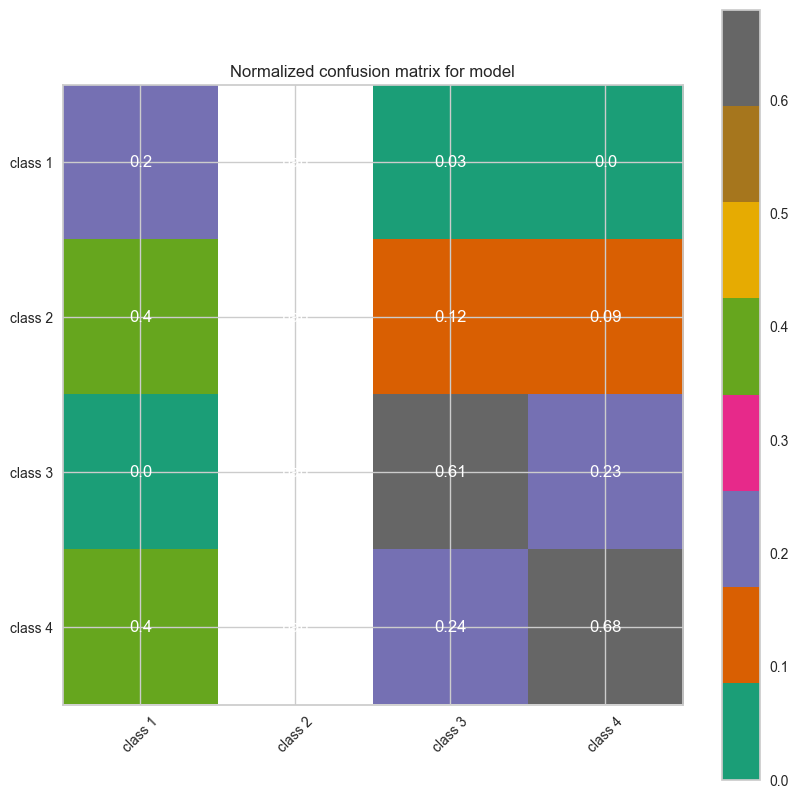

In [56]:
confusion_matrix_plot(cm_svm)

In [57]:
print("Classification Report:\n", classification_report(y_test, ypred3 , zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.20      0.09      0.13        11
           2       1.00      0.00      0.00        64
           3       0.61      0.87      0.72       279
           4       0.68      0.52      0.59       203

    accuracy                           0.63       557
   macro avg       0.62      0.37      0.36       557
weighted avg       0.67      0.63      0.58       557



In [58]:
# plot_ROC_curve(svm2, x_train, y_train, x_test, y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1297, 1) (1297,) (557, 1) (557,)


In [59]:
svm_score = table_score(ypred3)
svm_score.insert(0, 'Model', 'SVM')
svm_score

,Model,Recall,Precision,F1 Score,Accuracy
0,SVM,0.371011,0.623281,0.358882,0.628366


### Random Forest

In [60]:
RF = RandomForestClassifier(criterion = 'gini',n_estimators=100,max_depth=2) #criterion can be also : entropy 
RF.fit(x_train, y_train)
print("Test score: {:.2f}".format(RF.score(x_test , y_test)))

Test score: 0.62


In [61]:
param_grid_RF = { 
    'criterion': ['gini' , 'entropy'],
    'n_estimators': [100, 200, 300],
    'max_depth': [2 , 4 , 8]
}
clf_RF = GridSearchCV(estimator= RandomForestClassifier() , param_grid= param_grid_RF , cv=kfold, scoring='accuracy', verbose=3)
clf_RF.fit(x_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.715 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.669 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.638 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.662 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.662 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.738 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.662 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.698 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.682 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, n_estimators=100;, score=0.659 total time=   0.0s
[CV 1/

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 8],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=3)

In [62]:
print("Best of Hyper Parameter :" , clf_RF.best_params_, "\nScore : " , clf_RF.best_score_)

Best of Hyper Parameter : {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100} 
Score :  0.6939236732259989


In [63]:
RF2 = clf_RF.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(RF2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(RF2.score(x_train, y_train)))

Test score for test_data: 0.65
Test score for train_data: 0.71


In [64]:
scores_clf4 = cross_val_score(RF2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf4)
print("Mean for k_fold cross validation for Random Forest model", np.mean(scores_clf4))

[0.71538462 0.70769231 0.65384615 0.70769231 0.68461538 0.68461538
 0.65384615 0.68992248 0.71317829 0.68992248]
Mean for k_fold cross validation for Random Forest model 0.6900715563506262


In [65]:
ypred4 = RF2.predict(x_test)
cm_rf = confusion_matrix(y_test, ypred4)
print("confusion_matrix(ytest, ypred): \n", cm_rf)

confusion_matrix(ytest, ypred): 
 [[  5   0   6   0]
 [  5   0  53   6]
 [  2   0 247  30]
 [  2   0  89 112]]


In [66]:
sensitivity_specificity(cm_rf)

Sensitivity for each class: [0.45454545454545453, 0.0, 0.8853046594982079, 0.5517241379310345]
Specificity for each class: [0.9835164835164835, 1.0, 0.4676258992805755, 0.8983050847457628]
Sensitivity for each class:  0  is 0.45454545454545453
Specificity for each class: 0  is 0.9835164835164835
Sensitivity for each class:  1  is 0.0
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.8853046594982079
Specificity for each class: 2  is 0.4676258992805755
Sensitivity for each class:  3  is 0.5517241379310345
Specificity for each class: 3  is 0.8983050847457628


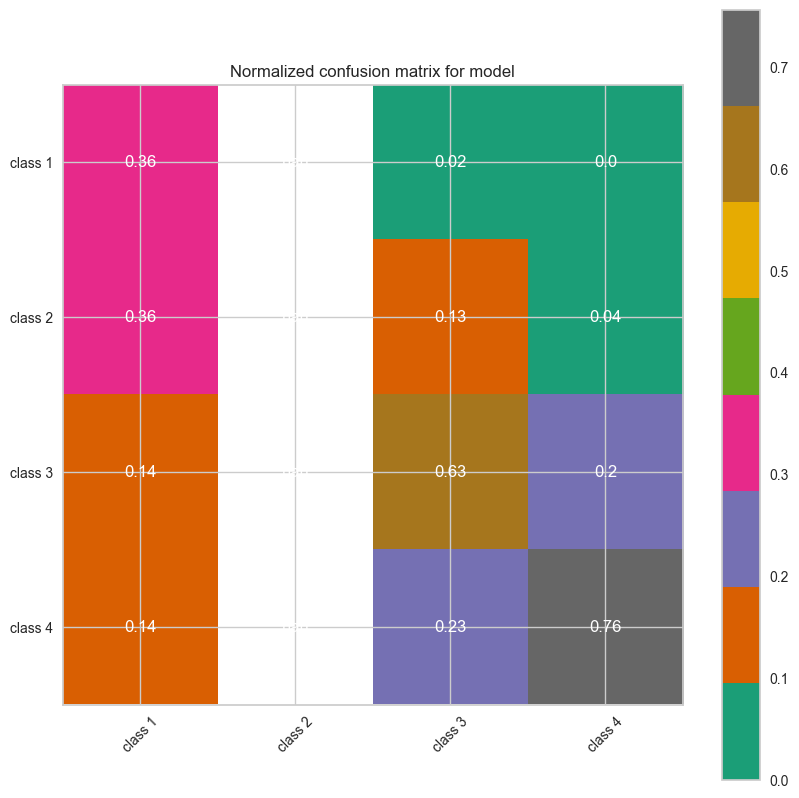

In [67]:
confusion_matrix_plot(cm_rf)

In [68]:
print("Classification Report:\n", classification_report(y_test, ypred4, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.36      0.45      0.40        11
           2       1.00      0.00      0.00        64
           3       0.63      0.89      0.73       279
           4       0.76      0.55      0.64       203

    accuracy                           0.65       557
   macro avg       0.68      0.47      0.44       557
weighted avg       0.71      0.65      0.61       557



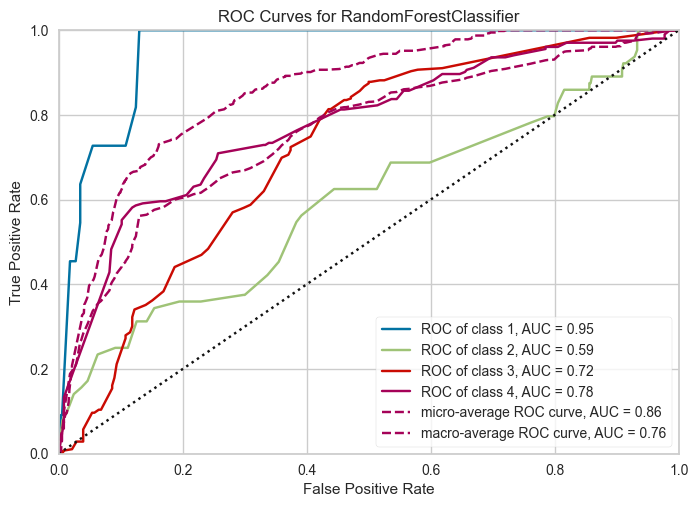

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=RandomForestClassifier(criterion='entropy', max_depth=8))

In [69]:
plot_ROC_curve(RF2, x_train, y_train, x_test, y_test)

In [70]:
rf_score = table_score(ypred4)
rf_score.insert(0, 'Model', 'RF')
rf_score

,Model,Recall,Precision,F1 Score,Accuracy
0,RF,0.472894,0.684804,0.442779,0.653501


### Naive Bayes

In [71]:
NB = GaussianNB()
NB.fit(x_train, y_train)
print("Test score: {:.2f}".format(NB.score(x_test , y_test)))

Test score: 0.63


In [72]:
param_grid_NB = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
}
clf_NB = GridSearchCV(estimator= GaussianNB() , param_grid= param_grid_NB , cv=kfold, scoring='accuracy', verbose=3)
clf_NB.fit(x_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END ..............var_smoothing=1e-09;, score=0.715 total time=   0.0s
[CV 2/10] END ..............var_smoothing=1e-09;, score=0.685 total time=   0.0s
[CV 3/10] END ..............var_smoothing=1e-09;, score=0.638 total time=   0.0s
[CV 4/10] END ..............var_smoothing=1e-09;, score=0.677 total time=   0.0s
[CV 5/10] END ..............var_smoothing=1e-09;, score=0.669 total time=   0.0s
[CV 6/10] END ..............var_smoothing=1e-09;, score=0.700 total time=   0.0s
[CV 7/10] END ..............var_smoothing=1e-09;, score=0.677 total time=   0.0s
[CV 8/10] END ..............var_smoothing=1e-09;, score=0.682 total time=   0.0s
[CV 9/10] END ..............var_smoothing=1e-09;, score=0.643 total time=   0.0s
[CV 10/10] END .............var_smoothing=1e-09;, score=0.659 total time=   0.0s
[CV 1/10] END ..............var_smoothing=1e-08;, score=0.715 total time=   0.0s
[CV 2/10] END ..............var_smoothing=1e-08;

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=3)

In [73]:
print("Best of Hyper Parameter :" , clf_NB.best_params_, "\nScore : " , clf_NB.best_score_)

Best of Hyper Parameter : {'var_smoothing': 1e-09} 
Score :  0.674603458556947


In [74]:
NB2 = clf_NB.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(NB2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(NB2.score(x_train, y_train)))

Test score for test_data: 0.63
Test score for train_data: 0.68


In [75]:
scores_clf5 = cross_val_score(NB2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf5)
print("Mean for k_fold cross validation for Naive Bayes model", np.mean(scores_clf5))

[0.71538462 0.68461538 0.63846154 0.67692308 0.66923077 0.7
 0.67692308 0.68217054 0.64341085 0.65891473]
Mean for k_fold cross validation for Naive Bayes model 0.674603458556947


In [76]:
ypred5 = NB2.predict(x_test)
cm_NB = confusion_matrix(y_test, ypred5)
print("confusion_matrix(ytest, ypred): \n", cm_NB)

confusion_matrix(ytest, ypred): 
 [[  1   0  10   0]
 [  2   0  48  14]
 [  1   0 242  36]
 [  2   0  95 106]]


In [77]:
sensitivity_specificity(cm_NB)

Sensitivity for each class: [0.09090909090909091, 0.0, 0.8673835125448028, 0.5221674876847291]
Specificity for each class: [0.9908424908424909, 1.0, 0.44964028776978415, 0.8587570621468926]
Sensitivity for each class:  0  is 0.09090909090909091
Specificity for each class: 0  is 0.9908424908424909
Sensitivity for each class:  1  is 0.0
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.8673835125448028
Specificity for each class: 2  is 0.44964028776978415
Sensitivity for each class:  3  is 0.5221674876847291
Specificity for each class: 3  is 0.8587570621468926


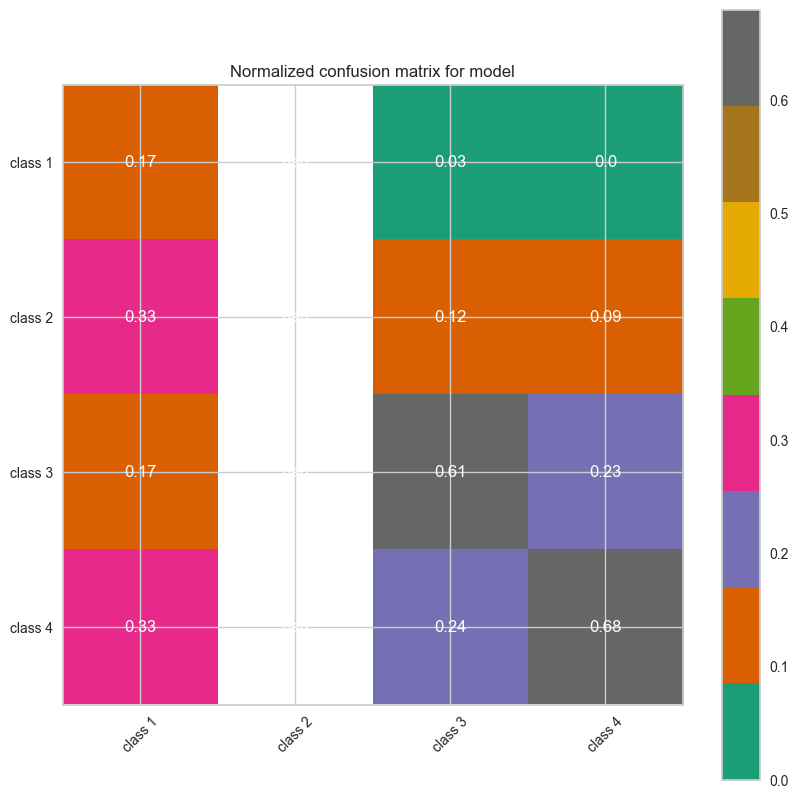

In [78]:
confusion_matrix_plot(cm_NB)

In [79]:
print("Classification Report:\n", classification_report(y_test, ypred5, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.09      0.12        11
           2       1.00      0.00      0.00        64
           3       0.61      0.87      0.72       279
           4       0.68      0.52      0.59       203

    accuracy                           0.63       557
   macro avg       0.61      0.37      0.36       557
weighted avg       0.67      0.63      0.58       557



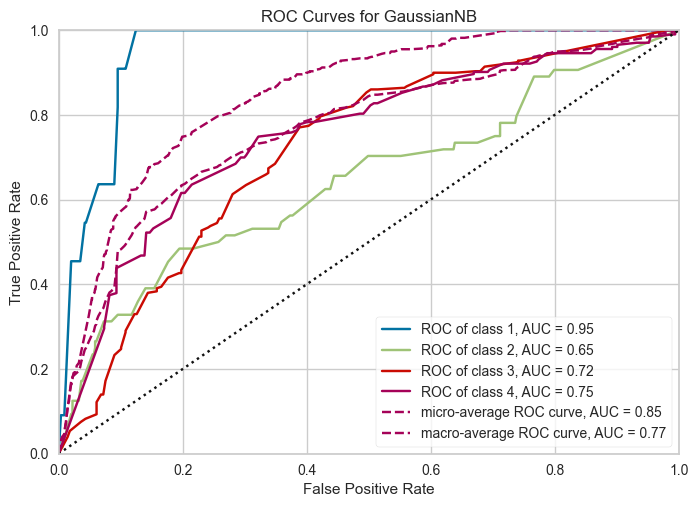

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'}, estimator=GaussianNB())

In [80]:
plot_ROC_curve(NB2, x_train, y_train, x_test, y_test)

In [81]:
nb_score = table_score(ypred5)
nb_score.insert(0, 'Model', 'NB')
nb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,NB,0.370115,0.614703,0.356569,0.626571


### Neural Network

In [82]:
MLP = MLPClassifier(activation='tanh',solver='sgd', hidden_layer_sizes=(5,), max_iter=5000, random_state=1)
MLP.fit(x_train,y_train)
print("Test score: {:.2f}".format(MLP.score(x_test, y_test)))

Test score: 0.50


In [83]:
param_grid_MLP = {
    'learning_rate_init': [0.001 , 0.01], 
    'batch_size': [1]
    # 'hidden_layer_sizes': [(20,), (50, 50)],
    # 'activation': ['relu', 'tanh'],
    # 'alpha': [0.0001, 0.01],
}
clf_MLP = GridSearchCV(estimator=MLPClassifier(), param_grid= param_grid_MLP , cv=kfold, scoring='accuracy' , verbose=3)
clf_MLP.fit(x_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END batch_size=1, learning_rate_init=0.001;, score=0.723 total time=  33.2s
[CV 2/10] END batch_size=1, learning_rate_init=0.001;, score=0.615 total time=  28.2s
[CV 3/10] END batch_size=1, learning_rate_init=0.001;, score=0.631 total time=  28.7s
[CV 4/10] END batch_size=1, learning_rate_init=0.001;, score=0.646 total time=  23.6s
[CV 5/10] END batch_size=1, learning_rate_init=0.001;, score=0.646 total time=  30.4s
[CV 6/10] END batch_size=1, learning_rate_init=0.001;, score=0.708 total time=  28.5s
[CV 7/10] END batch_size=1, learning_rate_init=0.001;, score=0.669 total time=  28.5s
[CV 8/10] END batch_size=1, learning_rate_init=0.001;, score=0.682 total time=  43.0s
[CV 9/10] END batch_size=1, learning_rate_init=0.001;, score=0.667 total time= 1.2min
[CV 10/10] END batch_size=1, learning_rate_init=0.001;, score=0.566 total time= 1.3min
[CV 1/10] END batch_size=1, learning_rate_init=0.01;, score=0.654 total time= 

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=MLPClassifier(),
             param_grid={'batch_size': [1],
                         'learning_rate_init': [0.001, 0.01]},
             scoring='accuracy', verbose=3)

In [84]:
print("Best of Hyper Parameter :" , clf_MLP.best_params_, "\nScore : " , clf_MLP.best_score_)

Best of Hyper Parameter : {'batch_size': 1, 'learning_rate_init': 0.001} 
Score :  0.6553190220632082


In [85]:
MLP2 = clf_MLP.best_estimator_.fit(x_train,y_train)
print("Test score for test_data: {:.2f}".format(MLP2.score(x_test, y_test)))
print("Test score for train_data: {:.2f}".format(MLP2.score(x_train, y_train)))

Test score for test_data: 0.57
Test score for train_data: 0.64


In [86]:
scores_clf6 = cross_val_score(MLP2, x_train, y_train, cv=kfold, scoring='accuracy')
print(scores_clf6)
print("Mean for k_fold cross validation for Neural Network model", np.mean(scores_clf6))

[0.71538462 0.68461538 0.62307692 0.64615385 0.55384615 0.70769231
 0.68461538 0.6744186  0.64341085 0.63565891]
Mean for k_fold cross validation for Neural Network model 0.6568872987477639


In [87]:
ypred6 = MLP2.predict(x_test)
cm_MLP = confusion_matrix(y_test, ypred6)
print("confusion_matrix(ytest, ypred): \n", cm_MLP)

confusion_matrix(ytest, ypred): 
 [[  1   0  10   0]
 [  2   0  56   6]
 [  1   0 258  20]
 [  2   0 140  61]]


In [88]:
sensitivity_specificity(cm_MLP)

Sensitivity for each class: [0.09090909090909091, 0.0, 0.9247311827956989, 0.30049261083743845]
Specificity for each class: [0.9908424908424909, 1.0, 0.2589928057553957, 0.9265536723163842]
Sensitivity for each class:  0  is 0.09090909090909091
Specificity for each class: 0  is 0.9908424908424909
Sensitivity for each class:  1  is 0.0
Specificity for each class: 1  is 1.0
Sensitivity for each class:  2  is 0.9247311827956989
Specificity for each class: 2  is 0.2589928057553957
Sensitivity for each class:  3  is 0.30049261083743845
Specificity for each class: 3  is 0.9265536723163842


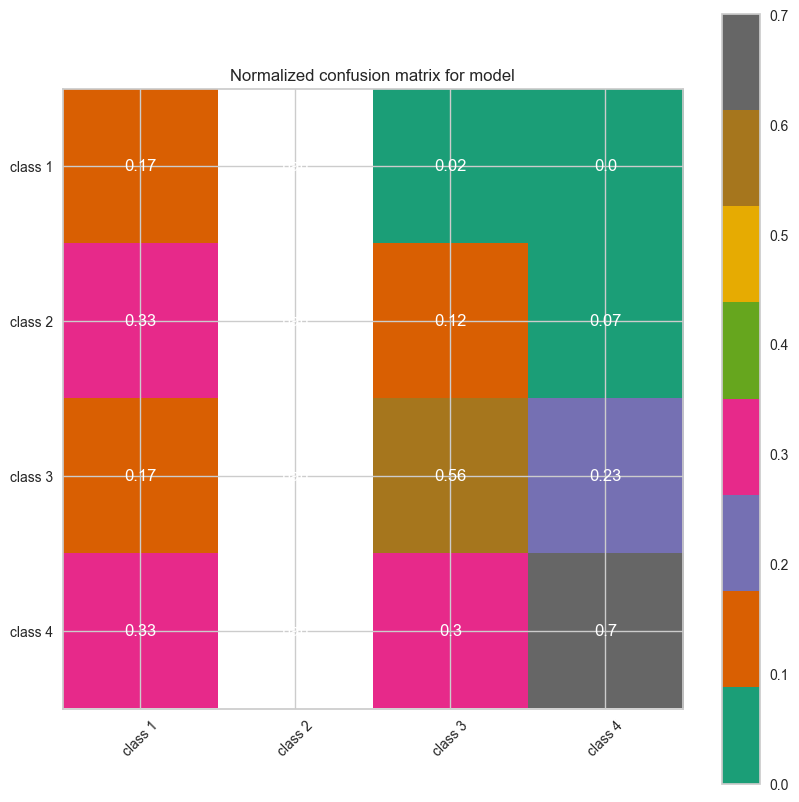

In [89]:
confusion_matrix_plot(cm_MLP)

In [90]:
print("Classification Report:\n", classification_report(y_test, ypred6, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.09      0.12        11
           2       1.00      0.00      0.00        64
           3       0.56      0.92      0.69       279
           4       0.70      0.30      0.42       203

    accuracy                           0.57       557
   macro avg       0.61      0.33      0.31       557
weighted avg       0.65      0.57      0.50       557



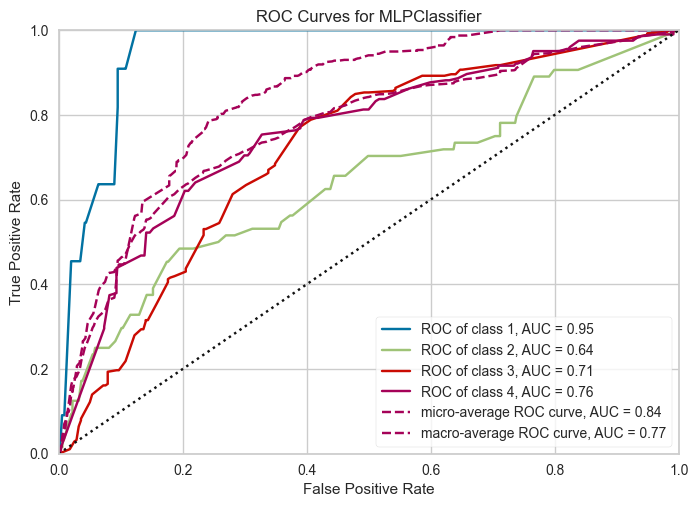

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4'},
       estimator=MLPClassifier(batch_size=1))

In [91]:
plot_ROC_curve(MLP2, x_train, y_train, x_test, y_test)

In [92]:
nn_score = table_score(ypred6)
nn_score.insert(0, 'Model', 'NN')
nn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,NN,0.329033,0.605963,0.308205,0.574506


### Result comparison

In [93]:
predictions = pd.concat([knn_score, lr_score, svm_score, rf_score, nb_score, nn_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Accuracy'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,KNN,0.478588,0.656067,0.434787,0.653501
3,RF,0.472894,0.684804,0.442779,0.653501
1,LR,0.371011,0.634019,0.360415,0.628366
2,SVM,0.371011,0.623281,0.358882,0.628366
4,NB,0.370115,0.614703,0.356569,0.626571
5,NN,0.329033,0.605963,0.308205,0.574506


### Visualization

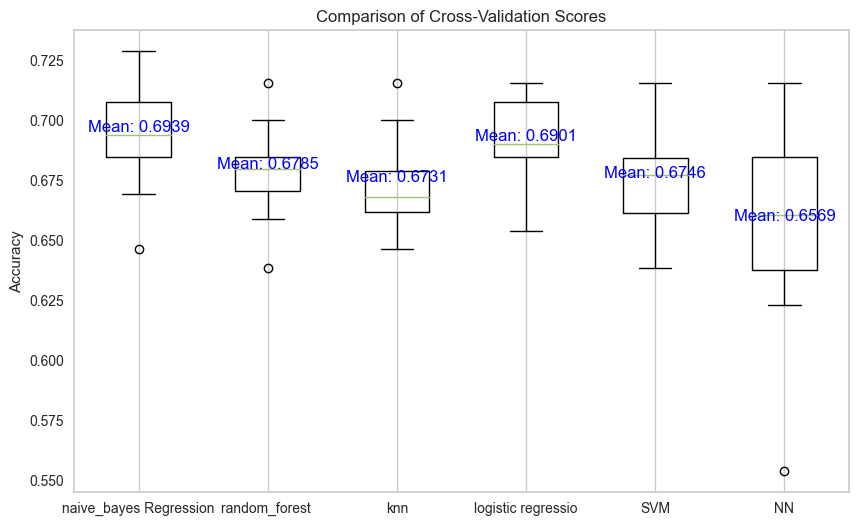

In [94]:
labels = ['naive_bayes Regression', 'random_forest ','knn','logistic regressio','SVM','NN']
data = [scores_clf1, scores_clf2,scores_clf3,scores_clf4,scores_clf5,scores_clf6]

plt.figure(figsize=(10, 6))
plt.boxplot(data)
plt.title('Comparison of Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 7), labels)
plt.grid(axis='y')

# Calculate and display mean scores
mean_scores = [np.mean(scores_clf1), np.mean(scores_clf2),np.mean(scores_clf3),np.mean(scores_clf4),np.mean(scores_clf5),np.mean(scores_clf6)]
for i, mean in enumerate(mean_scores, 1):
    plt.text(i, mean, f'Mean: {mean:.4f}', ha='center', va='bottom', color='blue')

plt.show()